<a href="https://colab.research.google.com/github/logikon-ai/logikon/blob/main/examples/legal_hallucination_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# *Build-Your-Own-Metrics #1*:<br>Fact Checking & Hallucination Detection for Legal Explanations

**Logikon `/\/`** – *Analyzing and Evaluating LLM Reasoning Traces*

#### Overview

This notebook illustrates how to build your own evaluations on top of metrics and artifacts created with **Logikon `/\/`**. More specifically, we'll use an argument map to factcheck an explanation produced by a Legal AI agent against a given reference corpus, which potentially allows us to detect so-called hallucinations. As this demo serves illustrative purposes, we're keeping the implementation of the Legal AI agent and the fact-checking pipeline as simple as possible.  

We're using 🤗's lightweight `zephyr-7b-beta` as **logic expert model** [below](#setup-b) for its speed and small footprint. It tends to produce argumentative analyses that are creative and eloquent, rather than rigorous and exact -- and may hence not be the optimal expert model for your use cases.

> ⚠️ **Important notice.**
>
> **Logikon `/\/`** is in early development stage:
> * the package is subject to change at any time;
> * results can vary due to changes in methods, pipelines, or underlying models;
> * current speed and quality of evaluation results are not representative of future product.


#### Table of contents

* **[Part I – Legal AI generates explanations (reasoning)](#part-a)**
* **[Part II – Analysing legal reasoning with Logikon `/\/`](#part-b)**
    * [Set-up](#setup-b)
    * [Select metrics and artifacts](#config_logikon)
    * [Run analysis](#run)
    * [Inspect results](#inspect)
* **[Part III – Fact-checking the Legal AI with Logikon `/\/` argument maps](#part-c)**


## Part I – Legal AI generates explanations (reasoning)<a name="part-a"></a>

In [1]:
%%capture
%pip install huggingface_hub

In [2]:
%%capture
# Optional: read environment variables from uploaded .env file, e.g. HUGGINGFACEHUB_API_TOKEN
%pip install python-dotenv
%load_ext dotenv
%dotenv .env

In [4]:
# LLM serving as legal expert
import os
from huggingface_hub import InferenceClient

legal_ai = InferenceClient(
    "mistralai/Mistral-7B-Instruct-v0.1",
    token=os.environ.get("HUGGINGFACEHUB_API_TOKEN"),
)
legal_gen_kwargs = {
    "max_new_tokens": 640,
    "temperature":.4,
    "do_sample": True,
    "seed": 42
}

In [5]:
prompt= (
    '<s>[INST] '
    'In the case BOWMAN v. MONSANTO the Supreme Court ruled that "patent exhaustion '
    'does not permit a farmer to reproduce patented seeds through planting and '
    'harvesting without the patent holder’s permission." Can you lay out the reasons '
    'that led the Supreme Court to reject Bowman\'s defence?'
    '[/INST]\n'
)

In [6]:
completion = legal_ai.text_generation(prompt, **legal_gen_kwargs)

from IPython.display import display, Markdown
display(Markdown(completion))


The Supreme Court case of Bowman v. Monsanto involved a farmer named Vernon Bowman who purchased soybean seeds from a grain elevator, which had obtained the seeds from a farmer who had purchased them from the patent holder, Monsanto. Bowman then planted the seeds on his own farm and harvested the resulting crops.

The court ruled in favor of Monsanto, stating that patent exhaustion does not permit a farmer to reproduce patented seeds through planting and harvesting without the patent holder's permission. The reasons for this decision were as follows:

1. The Supreme Court held that the doctrine of patent exhaustion applies only to the first sale of a patented product, and not to subsequent sales or uses of that product. This means that once a patented product has been sold, the patent holder no longer has the exclusive right to control its use or distribution.
2. In this case, the seeds that Bowman purchased from the grain elevator had already been sold by the patent holder, and the grain elevator had obtained them from a farmer who had purchased them from the patent holder. This means that the seeds were no longer within the scope of the original sale and were not covered by the doctrine of patent exhaustion.
3. The court also held that the farmer's actions of planting and harvesting the seeds constituted an infringement of the patent holder's exclusive right to reproduce the patented seeds. This is because the seeds were a key component of the patented soybean crop, and the farmer's actions allowed him to produce and sell crops that were identical to those produced by the patent holder.

Overall, the Supreme Court's decision in Bowman v. Monsanto rejected the farmer's defense of patent exhaustion and upheld the patent holder's exclusive right to control the use and distribution of their patented seeds.

## Part II – Analysing legal reasoning with **Logikon&nbsp;`/\/`** <a name="part-b"></a>

### Setting up notebook environment to run scoring script<a name="setup-b"></a>

In [7]:
# Please make sure that the following files from the `examples` folder
# in the `logikon-ai/logikon` GitHub repo are available.
!test -f "requirements.txt" || echo "Missing requirements.txt"
!test -f "setup.sh" || echo "Missing setup.sh"
!test -f "scoring.py" || echo "Missing scoring.py"

In [8]:
# Configure the environment
import os

os.environ["LGK_FRAMEWORK"] = "llamacpp"
os.environ["LGK_DEVICE"] = "gpu"
os.environ["LGK_HUBREPO"] = "TheBloke/zephyr-7B-beta-GGUF"
os.environ["LGK_MODELWEIGHTS"] = "zephyr-7b-beta.Q6_K.gguf"
os.environ["LGK_TOKENIZER"] = "HuggingFaceH4/zephyr-7b-beta"
os.environ["LGK_RELEASE"] = "main"

In [9]:
# Check gpu available
! [ "$LGK_DEVICE" = "gpu" ] && nvidia-smi

Wed Nov 22 13:50:26 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [10]:
%%capture
!sh setup.sh

In [11]:
# Path to model weights as env variable
import os

if os.environ.get("LGK_MODELWEIGHTS"):
    abspath = os.path.join(
        os.path.abspath("./models"),
        os.environ.get("LGK_MODELWEIGHTS")
    )
else:
    abspath = ""
os.environ["LGK_ABSPATH_MODELWEIGHTS"] = abspath
os.environ["LGK_ABSPATH_MODELWEIGHTS"]

'/content/models/zephyr-7b-beta.Q6_K.gguf'

In [12]:
# Check whether model weights file is available
!test -f "$LGK_ABSPATH_MODELWEIGHTS" || echo "Cannot find model weights"

In [13]:
# Post-processing prompt
# Inserting hints that point out which central claims to use in logical analysis
prompt_with_hint = prompt.replace("[INST]","").replace("[/INST]","").replace("<s>","").strip()
prompt_with_hint += " The central claim is simply: Bowman's defence should be rejected."

In [14]:
# Save reasoning traces to file
import pandas as pd
df_traces = pd.DataFrame([{"prompt": prompt_with_hint, "completion": completion}])
df_traces.to_json("reasoning_traces.jsonl", orient="records", lines=True)
# Check data file available
!head -2 "reasoning_traces.jsonl"

{"prompt":"In the case BOWMAN v. MONSANTO the Supreme Court ruled that \"patent exhaustion does not permit a farmer to reproduce patented seeds through planting and harvesting without the patent holder\u2019s permission.\" Can you lay out the reasons that led the Supreme Court to reject Bowman's defence? The central claim is simply: Bowman's defence should be rejected.","completion":"\nThe Supreme Court case of Bowman v. Monsanto involved a farmer named Vernon Bowman who purchased soybean seeds from a grain elevator, which had obtained the seeds from a farmer who had purchased them from the patent holder, Monsanto. Bowman then planted the seeds on his own farm and harvested the resulting crops.\n\nThe court ruled in favor of Monsanto, stating that patent exhaustion does not permit a farmer to reproduce patented seeds through planting and harvesting without the patent holder's permission. The reasons for this decision were as follows:\n\n1. The Supreme Court held that the doctrine of pa

### Select metrics and artifacts to calculate, and configure scoring methods <a name="config_logikon"></a>

In [15]:
# Write config als yaml file

config_dict = {
    # all metrics
    "metrics": ["argmap_size", "n_root_nodes", "mean_reason_strength"],
    # artifacts to generate
    "artifacts": ["fuzzy_argmap_nx", "svg_argmap"],
    "global_kwargs": {
        "expert_model": os.environ["LGK_ABSPATH_MODELWEIGHTS"],
        "expert_model_kwargs": {
            "n_ctx": 3072,
            # comment out line below if no gpu
            "n_gpu_layers": -1,
            "tokenizer": os.environ["LGK_TOKENIZER"],
            # custom prompt template, make sure this fits the expert_model
            "prompt_template": {
                "sys_start": "\n<|system|>\n",
                "sys_end": "",
                "user_start": "\n<|user|>\n",
                "user_end": "",
                "ass_start": "\n<|assistant|>\n",
                "ass_end": "",
            },
        },
        "generation_kwargs": {"max_len": 3072},
        "llm_framework": "llama.cpp",
    },
}

import yaml
with open('config.yml', 'w') as outfile:
    yaml.dump(config_dict, outfile, default_flow_style=False)

# Check config file available
!head -10 "config.yml" && echo "..."

artifacts:
- fuzzy_argmap_nx
- svg_argmap
global_kwargs:
  expert_model: /content/models/zephyr-7b-beta.Q6_K.gguf
  expert_model_kwargs:
    n_ctx: 3072
    n_gpu_layers: -1
    prompt_template:
      ass_end: ''
...


### Run argumentation analysis <a name="run"></a>

In [16]:
# 🫖 This will take some time ... you may monitor `scoring.log`
!python scoring.py \
  --config-file config.yml \
  --reasoning-traces-file reasoning_traces.jsonl

0it [00:00, ?it/s]/usr/bin/dot
The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.

0it [00:00, ?it/s]

tokenizer_config.json: 100% 1.43k/1.43k [00:00<00:00, 6.09MB/s]

tokenizer.model: 100% 493k/493k [00:00<00:00, 38.4MB/s]

tokenizer.json:   0% 0.00/1.80M [00:00<?, ?B/s]
tokenizer.json: 100% 1.80M/1.80M [00:00<00:00, 1.83MB/s]

added_tokens.json: 100% 42.0/42.0 [00:00<00:00, 196kB/s]

special_tokens_map.json: 100% 168/168 [00:00<00:00, 890kB/s]
[Loading llama.cpp model from llama.cpp:/content/models/zephyr-7b-beta.Q6_K.gguf  with  {'n_ctx': 3072, 'n_gpu_layers': -1} ]
2023-11-22 13:55:41.235427: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-22 13:55:41.235493: E t

### Inspect argumentation analysis <a name="inspect"></a>

In [17]:
# Read analysis results from file
df_scores = pd.read_json("outputs/reasoning_traces-scores.jsonl", lines=True)

In [18]:
# Display metric scores
df_scores[config_dict.get("metrics",[])].T.rename_axis("#example", axis="columns").rename_axis("metric", axis="rows")

#example,0
metric,
argmap_size,8.000000
n_root_nodes,2.000000
mean_reason_strength,0.668001


In [21]:
# Utility method for rendering artifacts
from pprint import pformat

import networkx as nx

from IPython.display import SVG, HTML, Markdown

from logikon.schemas.pros_cons import ProsConsList
from logikon.schemas.argument_mapping import FuzzyArgMap

def render_artifact(artifact_id, data):
  """helper function for rendering artifacts"""

  if "nx" in artifact_id:
    digraph = nx.node_link_graph(data)
    return Markdown(str(digraph))

  if "svg" in artifact_id:
    #style = "<style>svg{width:100% !important;height:100% !important;</style>"
    style = "<style>svg{width:100% !important;</style>"
    return HTML(style), SVG(data=data)

  if "html" in artifact_id:
    return HTML(data)

  if artifact_id == "proscons":
    proscons = ProsConsList(**data)
    return Markdown(f"`{pformat(proscons)}`")

  if artifact_id == "relevance_network":
    relnet = FuzzyArgMap(**data)
    return Markdown(f"`{pformat(relnet)[:800]} ...`")

  text = str(data)
  text = text[:200] + " ..." if len(text)>200 else text
  return Markdown(f"`{text}`")

> ⛔️ **Limitation**
>
> Note that the `zephyr-7b-beta` expert model struggles to correctly relate individual reasons to each other -- a task much better accomplished by larger LLMs.

## fuzzy_argmap_nx

DiGraph with 8 nodes and 6 edges

## svg_argmap

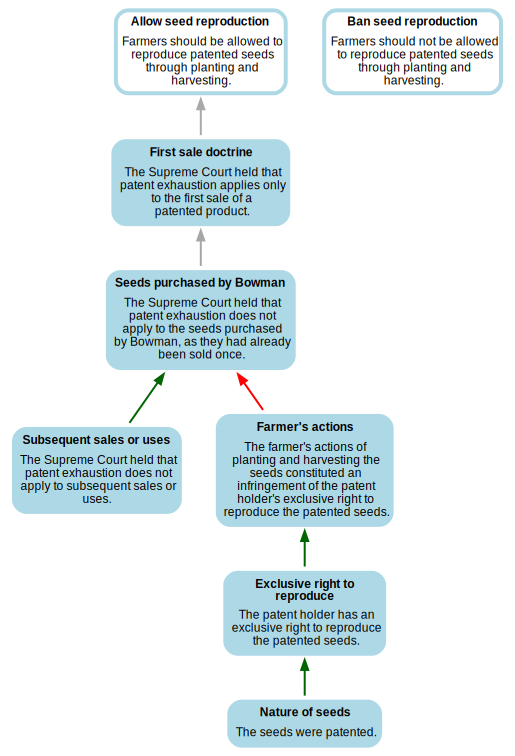

In [22]:
# Render argument map (and other generated artifacts)
from IPython.display import display, Markdown

example_idx = 0

for artifact_id in config_dict.get("artifacts",[]):
    display(Markdown(f"## {artifact_id}"))
    data = df_scores.iloc[example_idx].get(artifact_id)
    r = render_artifact(artifact_id, data)
    if isinstance(r, tuple):
        display(*r)
    else:
        display(r)



## Part III – Fact-checking the Legal AI with **Logikon `/\/`** argument maps<a name="part-c"></a>

In [23]:
# LLM serving as AI fact checker
import os
from huggingface_hub import InferenceClient

factchecker_ai = InferenceClient(
    "mistralai/Mistral-7B-Instruct-v0.1",
    token=os.environ.get("HUGGINGFACEHUB_API_TOKEN"),
)
factchecker_gen_kwargs = {
    "details": True,
    "max_new_tokens": 3,
    "temperature":.3,
    "do_sample": True,
}

In [24]:
# our reference corpus is a single text: simply an excerpt from the Supreme Court's decision
reference_text = """
SUPREME COURT OF THE UNITED STATES
No. 11-796
VERNON HUGH BOWMAN, PETITIONER v.
MONSANTO COMPANY ET AL.

[...]

Respondent Monsanto invented a genetic modification that enables soybean plants to survive exposure to glyphosate, the active ingredient in many herbicides (including Monsanto’s own Roundup). Monsanto markets soybean seed containing this altered genetic material as Roundup Ready seed. Farmers planting that seed can use a glyphosate- based herbicide to kill weeds without damaging their crops. Two patents issued to Monsanto cover various aspects of its Roundup Ready technology, including a seed in- corporating the genetic alteration. See Supp. App. SA1–21 (U. S. Patent Nos. 5,352,605 and RE39,247E); see also 657 F. 3d 1341, 1343–1344 (CA Fed. 2011).

Monsanto sells, and allows other companies to sell, Roundup Ready soybean seeds to growers who assent to a special licensing agreement. See App. 27a. That agreement permits a grower to plant the purchased seeds in one (and only one) season. He can then consume the resulting crop or sell it as a commodity, usually to a grain elevator or agricultural processor. See 657 F. 3d, at 1344–1345. But under the agreement, the farmer may not save any of the harvested soybeans for replanting, nor may he supply them to anyone else for that purpose. These restrictions reflect the ease of producing new generations of Roundup Ready seed. Because glyphosate resistance comes from the seed’s genetic material, that trait is passed on from the planted seed to the harvested soybeans: Indeed, a single Roundup Ready seed can grow a plant containing dozens of genetically identical beans, each of which, if replanted, can grow another such plant—and so on and so on. See App. 100a. The agreement’s terms prevent the farmer from co-opting that process to produce his own Roundup Ready seeds, forcing him instead to buy from Monsanto each season.

Petitioner Vernon Bowman is a farmer in Indiana who, it is fair to say, appreciates Roundup Ready soybean seed. He purchased Roundup Ready each year, from a company affiliated with Monsanto, for his first crop of the season. In accord with the agreement just described, he used all of that seed for planting, and sold his entire crop to a grain elevator (which typically would resell it to an agricultural processor for human or animal consumption).

Bowman, however, devised a less orthodox approach for his second crop of each season. Because he thought such late-season planting “risky,” he did not want to pay the premium price that Monsanto charges for Roundup Ready seed. He therefore went to a grain elevator; purchased “commodity soybeans” intended for human or animal consumption; and planted them in his fields.1 Those soybeans came from prior harvests of other local farmers. And because most of those farmers also used Roundup Ready seed, Bowman could anticipate that many of the purchased soybeans would contain Monsanto’s patented technology. When he applied a glyphosate-based herbicide to his fields, he confirmed that this was so; a significant proportion of the new plants survived the treatment, and produced in their turn a new crop of soybeans with the Roundup Ready trait. Bowman saved seed from that crop to use in his late-season planting the next year—and then the next, and the next, until he had harvested eight crops in that way. Each year, that is, he planted saved seed from the year before (sometimes adding more soybeans bought from the grain elevator), sprayed his fields with glyphosate to kill weeds (and any non-resistant plants), and produced a new crop of glyphosate- resistant—i.e., Roundup Ready—soybeans.

After discovering this practice, Monsanto sued Bowman for infringing its patents on Roundup Ready seed. Bowman raised patent exhaustion as a defense, arguing that Monsanto could not control his use of the soybeans because they were the subject of a prior authorized sale (from local farmers to the grain elevator). The District Court rejected that argument, and awarded damages to Monsanto of $84,456. The Federal Circuit affirmed. It reasoned that patent exhaustion did not protect Bowman because he had “created a newly infringing article.” 657 F. 3d, at 1348. The “right to use” a patented article following an authorized sale, the court explained, “does not include the right to construct an essentially new article on the template of the original, for the right to make the article remains with the patentee.” Ibid. (brackets and internal quotation marks omitted). Accordingly, Bowman could not “‘replicate’ Monsanto’s patented technology by planting it in the ground to create newly infringing genetic material, seeds, and plants.” Ibid.
"""
from IPython.display import display, Markdown
display(Markdown(reference_text))


SUPREME COURT OF THE UNITED STATES
No. 11-796
VERNON HUGH BOWMAN, PETITIONER v.
MONSANTO COMPANY ET AL.

[...]

Respondent Monsanto invented a genetic modification that enables soybean plants to survive exposure to glyphosate, the active ingredient in many herbicides (including Monsanto’s own Roundup). Monsanto markets soybean seed containing this altered genetic material as Roundup Ready seed. Farmers planting that seed can use a glyphosate- based herbicide to kill weeds without damaging their crops. Two patents issued to Monsanto cover various aspects of its Roundup Ready technology, including a seed in- corporating the genetic alteration. See Supp. App. SA1–21 (U. S. Patent Nos. 5,352,605 and RE39,247E); see also 657 F. 3d 1341, 1343–1344 (CA Fed. 2011).

Monsanto sells, and allows other companies to sell, Roundup Ready soybean seeds to growers who assent to a special licensing agreement. See App. 27a. That agreement permits a grower to plant the purchased seeds in one (and only one) season. He can then consume the resulting crop or sell it as a commodity, usually to a grain elevator or agricultural processor. See 657 F. 3d, at 1344–1345. But under the agreement, the farmer may not save any of the harvested soybeans for replanting, nor may he supply them to anyone else for that purpose. These restrictions reflect the ease of producing new generations of Roundup Ready seed. Because glyphosate resistance comes from the seed’s genetic material, that trait is passed on from the planted seed to the harvested soybeans: Indeed, a single Roundup Ready seed can grow a plant containing dozens of genetically identical beans, each of which, if replanted, can grow another such plant—and so on and so on. See App. 100a. The agreement’s terms prevent the farmer from co-opting that process to produce his own Roundup Ready seeds, forcing him instead to buy from Monsanto each season.

Petitioner Vernon Bowman is a farmer in Indiana who, it is fair to say, appreciates Roundup Ready soybean seed. He purchased Roundup Ready each year, from a company affiliated with Monsanto, for his first crop of the season. In accord with the agreement just described, he used all of that seed for planting, and sold his entire crop to a grain elevator (which typically would resell it to an agricultural processor for human or animal consumption).

Bowman, however, devised a less orthodox approach for his second crop of each season. Because he thought such late-season planting “risky,” he did not want to pay the premium price that Monsanto charges for Roundup Ready seed. He therefore went to a grain elevator; purchased “commodity soybeans” intended for human or animal consumption; and planted them in his fields.1 Those soybeans came from prior harvests of other local farmers. And because most of those farmers also used Roundup Ready seed, Bowman could anticipate that many of the purchased soybeans would contain Monsanto’s patented technology. When he applied a glyphosate-based herbicide to his fields, he confirmed that this was so; a significant proportion of the new plants survived the treatment, and produced in their turn a new crop of soybeans with the Roundup Ready trait. Bowman saved seed from that crop to use in his late-season planting the next year—and then the next, and the next, until he had harvested eight crops in that way. Each year, that is, he planted saved seed from the year before (sometimes adding more soybeans bought from the grain elevator), sprayed his fields with glyphosate to kill weeds (and any non-resistant plants), and produced a new crop of glyphosate- resistant—i.e., Roundup Ready—soybeans.

After discovering this practice, Monsanto sued Bowman for infringing its patents on Roundup Ready seed. Bowman raised patent exhaustion as a defense, arguing that Monsanto could not control his use of the soybeans because they were the subject of a prior authorized sale (from local farmers to the grain elevator). The District Court rejected that argument, and awarded damages to Monsanto of $84,456. The Federal Circuit affirmed. It reasoned that patent exhaustion did not protect Bowman because he had “created a newly infringing article.” 657 F. 3d, at 1348. The “right to use” a patented article following an authorized sale, the court explained, “does not include the right to construct an essentially new article on the template of the original, for the right to make the article remains with the patentee.” Ibid. (brackets and internal quotation marks omitted). Accordingly, Bowman could not “‘replicate’ Monsanto’s patented technology by planting it in the ground to create newly infringing genetic material, seeds, and plants.” Ibid.


In [25]:
prompt_factchecking= (
    '<s>[INST] '
    'Assignment: Determine whether a claim is asserted or implied by a reference text.\n'
    'Read the following reference text carefully:\n'
    '<text>\n{text}\n</text>'
    'You are supposed to judge whether the reference text contains (states or implies) '
    'the following claim:\n'
    '<claim>\n{claim}\n</claim>'
    'Now, re-read the text carefully, and check whether the claim is true according to '
    'the text.\n'
    'Does the text assert or imply the claim?\n'
    '(A) The text implies that the claim is true.'
    '(B) The text does not imply that the claim is true.'
    'Just answer with "A" or "B", you\'ll have the opportunity to explain '
    'your answer later.'
    '[/INST]\n'
)

In [26]:
# monte-carlo inference to estimate confidence levels
def factual_accuracy(claim, N=9):
    """factchecker_ai's confidence in claim being implied by reference_text"""
    completions = []
    for i in range(N):
        completion = factchecker_ai.text_generation(
            prompt_factchecking.format(
                text=reference_text,
                claim=claim,
            ),
            seed=i,
            **factchecker_gen_kwargs,
        )
        completions.append(completion)
    token_texts = [
        [t.text for t in c.details.tokens]
        for c in completions
    ]
    count_asserted = sum(('A' in tts) for tts in token_texts)
    return count_asserted/N

In [27]:
import pandas as pd

# get reconstructed argument map
argmap = df_scores.iloc[0].get("fuzzy_argmap_nx")

# score factual accuracy of each reason claim in argmap
hallucination_data = []
for node in argmap["nodes"]:
  if node.get("node_type") == "reason":
    text = node.get("text")
    factivity_score = factual_accuracy(text) if text else None
    hallucination_data.append({
        "label": node.get("label"),
        "text": text,
        "factual_accuracy": factivity_score,
    })
df_factivity = pd.DataFrame(hallucination_data)

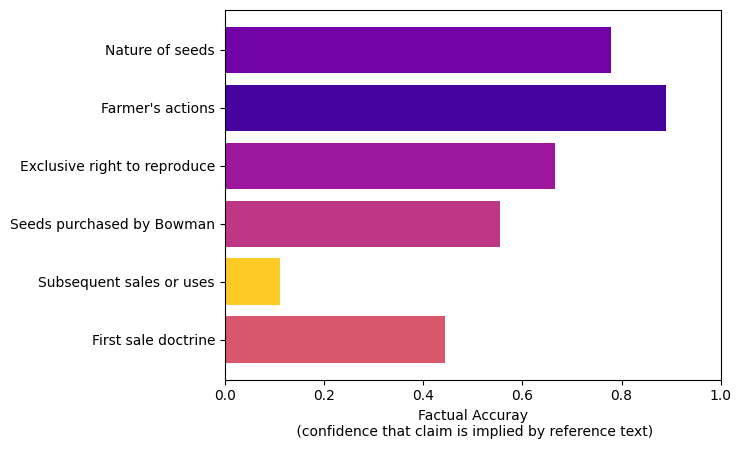

In [28]:
# plot factual accuracy of reason claims
import matplotlib.pyplot as plt

cmap = plt.get_cmap("plasma_r")

fig, ax = plt.subplots()
ax.barh(width="factual_accuracy", y="label", data=df_factivity, color=cmap(df_factivity.factual_accuracy.values))
ax.set_xlim(0,1)
ax.set_xlabel("Factual Accuray\n (confidence that claim is implied by reference text)")
plt.show()


****

(c) 2023 The Logikon AI Team | License: Apache 2.0